In [1]:
import copy

import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [3]:
TRAIN_PATH = "./titanic/train.csv"
TEST_PATH = "./titanic/test.csv"
SAMPLE_SUBMISSION_PATH = "./titanic/gender_submission.csv"
SUBMISSION_PATH = "submission.csv"

In [4]:
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
ID = 'PassengerId'
TARGET = 'Survived'

In [182]:
# 读取训练集文件，并查看相关信息
train_data = pd.read_csv(TRAIN_PATH)

# 一、查看文件中的数据，进行数据分析

In [7]:
train_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [163]:
train_data.info() # 其中Age只有714个数据，缺少了891-714个数据；Cabin仅有204个，Embarked缺少2个数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [183]:
# 其中PassengerId、Name、Ticket与是否生存无关，所以删除掉
train_data = train_data.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

In [96]:
train_data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S


In [97]:
train_data.info() # 其中Age只有714个数据，缺少了891-714个数据；Cabin仅有204个，Embarked缺少2个数据

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Cabin     204 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB


# Survived（存活基本情况）

In [12]:
# 891人当中，共有多少人生还
total_survived_num = train_data['Survived'].sum()
total_no_survived_num = 891 - total_survived_num
print(f"生还者总共{total_survived_num}人，死亡者总共{total_no_survived_num}人")

生还者总共342人，死亡者总共549人


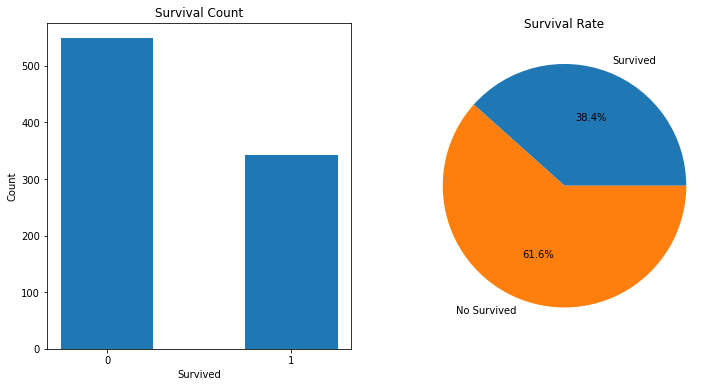

In [24]:
plt.figure(figsize=(12, 6))
# 绘制柱状图
plt.subplot(1,2, 1)
plt.bar([1, 0], [total_survived_num, total_no_survived_num], width=0.5)
plt.xticks(ticks=[0, 1])
plt.title('Survival Count')
plt.xlabel('Survived')
plt.ylabel('Count')

# 绘制饼状图
plt.subplot(1, 2, 2)
plt.pie([total_survived_num, total_no_survived_num],
        labels=['Survived', 'No Survived'], autopct="%.1f%%")
plt.title('Survival Rate')
plt.show()

**这891名乘客中，生还和未生还的比例分别为38.4%和61.6%。**

**下面，分别分析 Pclass、Sex、Age、SibSp、Parch、Fare、Cabin 和 Embarked 等与“生还”的关系**

# Pclass（客舱等级）
# 不同级别客舱的人数和比例

In [56]:
x = train_data[['Pclass', 'Survived']].groupby(['Pclass']).count()
x

,Survived
Pclass,
1,216
2,184
3,491


**可以看到，其中客舱等级分为1、2、3，分别有216人，184人，491人**

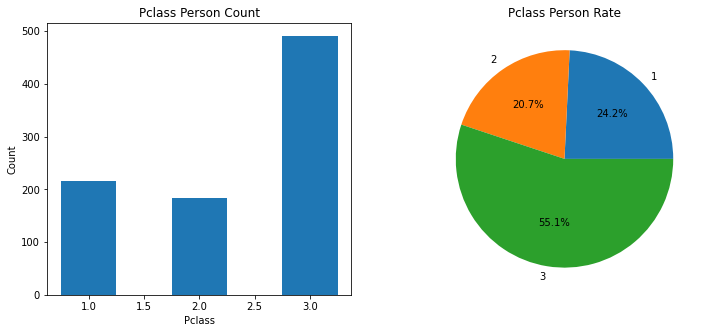

In [64]:
plt.figure(figsize=(12, 5))
# 绘制柱状图
plt.subplot(1, 2, 1)
plt.bar([1, 2, 3], x['Survived'], width=0.5)
plt.title('Pclass Person Count')
plt.xlabel('Pclass')
plt.ylabel('Count')
# 绘制饼状图
plt.subplot(1, 2, 2)
plt.pie(x['Survived'], labels=[1, 2, 3], autopct='%.1f%%')
plt.title('Pclass Person Rate')
plt.show()

**海难发生前，一等舱、二等舱、三等舱的乘客分别为216、184、491人，分别占总人数的 24.2%， 20.7%， 55.1%**

# 不同级别客舱生还人数

In [68]:
x = train_data[train_data['Survived'] == 1]
x = x[['Pclass', 'Survived']].groupby('Pclass').count()
x

,Survived
Pclass,
1,136
2,87
3,119


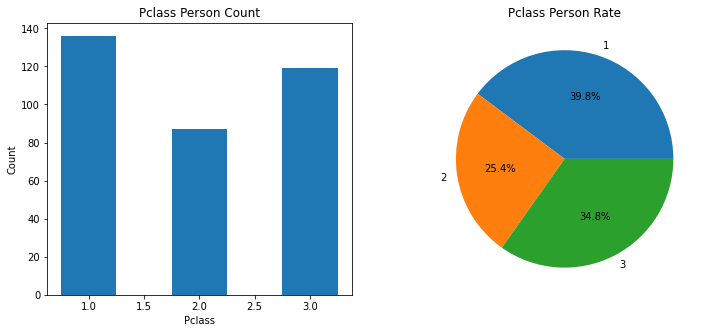

In [69]:
plt.figure(figsize=(12, 5))
# 绘制柱状图
plt.subplot(1, 2, 1)
plt.bar([1, 2, 3], x['Survived'], width=0.5)
plt.title('Pclass Person Count')
plt.xlabel('Pclass')
plt.ylabel('Count')
# 绘制饼状图
plt.subplot(1, 2, 2)
plt.pie(x['Survived'], labels=[1, 2, 3], autopct='%.1f%%')
plt.title('Pclass Person Rate')
plt.show()

**海难发生前，一等舱、二等舱、三等舱的乘客分别为216、184、491人，分别占总人数的 24.2%， 20.7%， 55.1%**
**海难发生后，一等舱、二等舱、三等舱的乘客分别为136、87、119人，分别占总人数的 39.8%， 25.4%， 34.8%**
**一等舱生还率为 63%，二等舱为 47%，三等舱为 24%。可见客舱等级越高，生还率越高。**

# Sex（性别）
# 不同性别人数比例及生还率

In [71]:
x = train_data[['Sex', 'Survived']].groupby('Sex').count()
x

,Survived
Sex,
female,314
male,577


In [73]:
x = train_data[train_data['Survived'] == 1]
x = x[['Sex', 'Survived']].groupby('Sex').count()
x

,Survived
Sex,
female,233
male,109


**海难发生前，男有577人，女有314人，海难发生后，存活的男有109人，存活的女有233人**

In [82]:
male_survived_rate = 109 / 577
female_survived_rate = 233 / 314
print("男生存活率：%.1f%%，女生存活率：%.1f%%" %(male_survived_rate*100, female_survived_rate*100))

男生存活率：18.9%，女生存活率：74.2%


# Age（年龄）
# 不同年龄比例及生还率

**由于Age是有缺失值的，所以先处理缺失值问题。填充的年龄为年龄平均值。**

In [184]:
# 查看缺少的年龄数
nan_age_count = train_data['Age'].isnull().sum()
print(f"缺少的年龄数：{nan_age_count}")
# 求年龄平均值
avg_age = train_data['Age'].mean()
print(f"年龄平均值：{avg_age}")
# 填充缺失的年龄
train_data['Age'] = train_data['Age'].fillna(avg_age)

缺少的年龄数：177
年龄平均值：29.69911764705882


In [170]:
train_data['Age'].describe()

count    891.000000
mean      29.699118
std       13.002015
min        0.420000
25%       22.000000
50%       29.699118
75%       35.000000
max       80.000000
Name: Age, dtype: float64

**此时年龄不缺了，可以查看年龄分布**

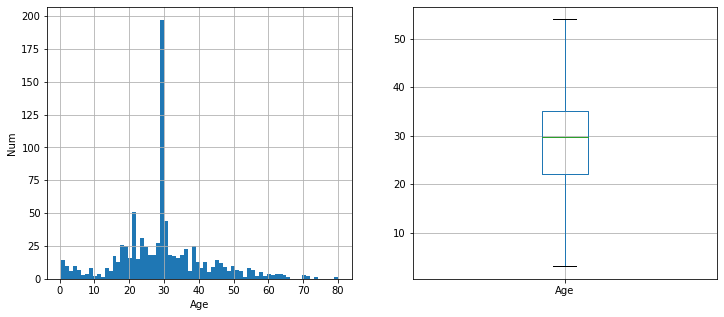

In [106]:
plt.figure(figsize=(12, 5))
# 绘制年龄分布图
plt.subplot(1, 2, 1)
train_data['Age'].hist(bins = 70)
plt.xlabel('Age')
plt.ylabel('Num')
# 绘制年龄分布图
plt.subplot(1, 2, 2)
train_data.boxplot(column='Age', showfliers=False)
plt.show()

**样本的891人中，平均年龄约为30岁，标准差为13岁，最小年龄0.42岁，最大年龄80岁**
## 按照年龄，将乘客划分为儿童，少年，成年人，老年人，分析四个群体的生还情况

In [125]:
children_df = train_data[train_data['Age'] <= 12]
juvenile_df = train_data[(train_data['Age'] > 12) & (train_data['Age'] < 18)]
adults_df = train_data[(train_data['Age'] >= 18) & (train_data['Age'] < 65)]
agedness_df = train_data[train_data['Age'] >= 65]

In [126]:
# 儿童数量
children_count = children_df['Survived'].count()
# 少年数量
juvenile_count = juvenile_df['Survived'].count()
# 成年人数量
adults_count = adults_df['Survived'].count()
# 老年人数量
agedness_count = agedness_df['Survived'].count()
children_count, juvenile_count, adults_count, agedness_count

(69, 44, 767, 11)

In [127]:
# 儿童中存活的数量
children_survived_count = children_df['Survived'].sum()
# 少年中存活的数量
juvenile_survived_count = juvenile_df['Survived'].sum()
# 成年人中存活的数量
adults_survived_count = adults_df['Survived'].sum()
# 老年人中存活的数量
agedness_survived_count = agedness_df['Survived'].sum()
children_survived_count, juvenile_survived_count, adults_survived_count, agedness_survived_count

(40, 21, 280, 1)

In [128]:
children_survived_rate = 40 / 69
juvenile_survived_rate = 21 / 44
adults_survived_rate = 280 / 767
agedness_survived_rate = 1 / 11
print("儿童存活率：%.1f%%，少年存活率：%.1f%%" %(children_survived_rate*100, juvenile_survived_rate*100))
print("成年人存活率：%.1f%%，老年人存活率：%.1f%%" %(adults_survived_rate*100, agedness_survived_rate*100))

儿童存活率：58.0%，少年存活率：47.7%
成年人存活率：36.5%，老年人存活率：9.1%


# SibSp（兄弟姐妹）
# 有兄弟姐妹的乘客生还人数和生还率

In [131]:
sibsp_df = train_data[train_data['SibSp'] != 0]
no_sibsp_df = train_data[train_data['SibSp'] == 0]
# 有兄弟姐妹的乘客数
sibsp_count = sibsp_df['Survived'].count()
# 没有兄弟姐妹的乘客数
no_sibsp_count = no_sibsp_df['Survived'].count()
sibsp_count, no_sibsp_count

(283, 608)

In [132]:
# 有兄弟姐妹的乘客生还数
sibsp_survived_count = sibsp_df['Survived'].sum()
# 没有兄弟姐妹的乘客生还数
no_sibsp_survived_count = no_sibsp_df['Survived'].sum()
sibsp_survived_count, no_sibsp_survived_count

(132, 210)

In [133]:
sibsp_survived_rate = 132 / 283
no_sibsp_survived_rate = 210 / 608
print("有兄弟姐妹的存活率：%.1f%%，没有兄弟姐妹的存活率：%.1f%%" %(sibsp_survived_rate*100, no_sibsp_survived_rate*100))

有兄弟姐妹的存活率：46.6%，没有兄弟姐妹的存活率：34.5%


# Parch（父母子女）
# 有父母子女的乘客生还人数和生还率

In [134]:
parch_df = train_data[train_data['Parch'] != 0]
no_parch_df = train_data[train_data['Parch'] == 0]
# 有父母子女的乘客数
parch_count = parch_df['Survived'].count()
# 没有父母子女的乘客数
no_parch_count = no_parch_df['Survived'].count()
parch_count, no_parch_count

(213, 678)

In [135]:
# 有父母子女的乘客生还数
parch_survived_count = parch_df['Survived'].sum()
# 没有父母子女的乘客生还数
no_parch_survived_count = no_parch_df['Survived'].sum()
parch_survived_count, no_parch_survived_count

(109, 233)

In [136]:
parch_survived_rate = 109 / 213
no_parch_survived_rate = 233 / 678
print("有父母子女的存活率：%.1f%%，没有父母子女的存活率：%.1f%%" %(parch_survived_rate*100, no_parch_survived_rate*100))

有父母子女的存活率：51.2%，没有父母子女的存活率：34.4%


# Fare（票价）
# 票价分布

In [148]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

**绘制所有的票价分布图**

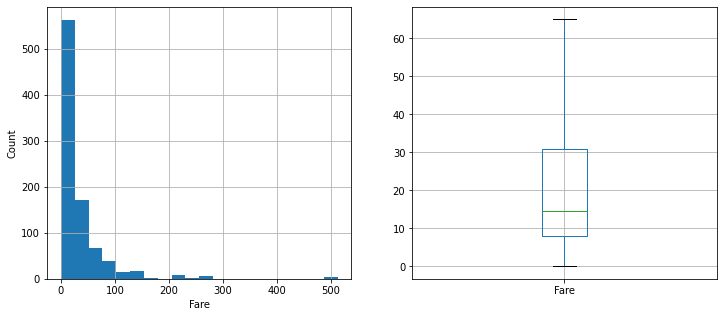

In [156]:
plt.figure(figsize=(12, 5))
# 绘制票价分布图
plt.subplot(1, 2, 1)
train_data['Fare'].hist(bins = 20)
plt.xlabel('Fare')
plt.ylabel('Count')
# 绘制盒图
plt.subplot(1, 2, 2)
train_data.boxplot(column='Fare', showfliers=False)
plt.show()

**绘制存活乘客的票价分布图**

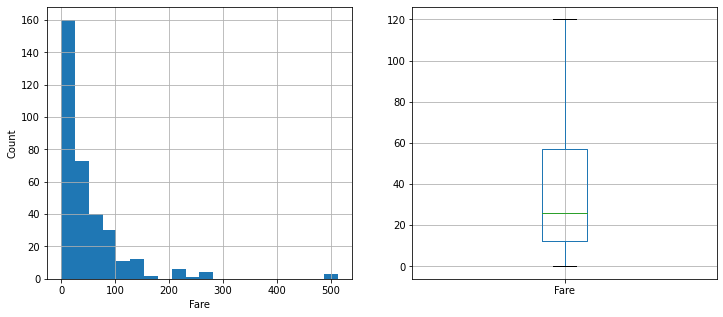

In [157]:
plt.figure(figsize=(12, 5))
# 绘制存活乘客的票价分布图
plt.subplot(1, 2, 1)
train_data[train_data['Survived'] == 1]['Fare'].hist(bins = 20)
plt.xlabel('Fare')
plt.ylabel('Count')
# 绘制存活乘客的票价盒图
plt.subplot(1, 2, 2)
train_data[train_data['Survived'] == 1].boxplot(column='Fare', showfliers=False)
plt.show()

# Cabin（船舱）
# 丢失值太多，不能用此数据分析出Cabin对生存率的影响，丢掉

In [185]:
train_data = train_data.drop('Cabin', axis=1)

In [186]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


# Embarked（登船港口）
# 各个港口上船人数及生还率
**由于Embarked有两个缺失值，所以这里使用众数来填充**

In [188]:
# 统计各个（港口）出现的次数
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [189]:
# S出现的次数最多，所以用S来填充两个缺失的数
train_data['Embarked'] = train_data['Embarked'].fillna('S')

In [192]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


**填充后，各个港口登船的乘客数**

In [193]:
train_data['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

**海难后，各个港口登船的存活乘客数**

In [194]:
train_data[train_data['Survived'] == 1]['Embarked'].value_counts()

S    219
C     93
Q     30
Name: Embarked, dtype: int64

**统计各个港口登船的存活率**

In [195]:
S_survived_rate = 219 / 646
C_survived_rate = 93 / 168
Q_survived_rate = 30 / 77
print("S港口存活率：%.1f%%，C港口存活率：%.1f%%，Q港口存活率：%.1f%%" %(S_survived_rate*100, C_survived_rate*100,Q_survived_rate*100))

S港口存活率：33.9%，C港口存活率：55.4%，Q港口存活率：39.0%


# 二、数据分析总结
本次分析主要寻找了泰坦尼克号上的生还率与各因素（客舱等级、年龄、性别、上船港口等）的关系。

1. 样本数量为891，海难发生后，生还者还剩342人，生还率为38.4%。

2. 泰坦尼克号上有一、二、三等舱三种船舱类型。
        海难发生前，一等舱有 216 人，二等舱 184 人，三等舱 491 人，分别占总人数的 24%， 21%， 55%。
        海难发生后，一等舱、二等舱、三等舱的乘客人数变为136、87、119人，分别占总人数的 40%, 25%, 35%。
        一等舱生还率为 63%，二等舱为 47%，三等舱为 24%。可见客舱等级越高，生还率越高。

3. 海难发生前，男性共577人，女性314人，男女比例为 65% 和 35%。
        海难发生后，男性变为109人，女性变为233人，男女比例变为 32% 和 68%。
        男性生还109人，生还率仅为19%。女性生还233人，生还率为74%，远远高于男性的19%。可见女性比男性在这次事故中更容易生还，表明“女士优先”的原则在本次事故中得到了发扬。

4. 样本的891人中，平均年龄约为30岁， 标准差15岁，最小年龄为0.42，最大年龄80。按照儿童（0-12）、少年（12-18）、成人（18-65）、老年人（65及以上）划分为四类。
        四类人的生还率分别为58%，48%，39% 和9%。可见年龄越大，生还率越低。“尊老爱幼”的原则在本次事故中没有很好体现。

5. 有兄弟姐妹的乘客有283人，生还132人，生还率为47%，
        而没有兄弟姐妹的乘客，有608人，生还210人，生还率为35%。可见有兄弟姐妹同船的生还率比没有兄弟姐妹同船的生还率要高。

6. 有父母或子女同船的乘客有213人，生还109人，生还率为51%。
        没有父母子女同船的乘客有678人，生还233人，生还率仅为34%。
   可见有父母或子女同船的生还率比没有的生还率要高。综合前一条分析，可以得出推论，有家人在船上的比没有家人在船上的生还概率要大。

7. 票价与生还有一定相关性，生还者的平均票价要比未生还的高。

8. S港口生还人数最多，C次之，Q最少。从生还率来看，C港上船的生还率最高，Q次之，S生还率最低。

# 三、构建模型训练

## 1.处理数据缺失值

In [495]:
train_data = pd.read_csv(TRAIN_PATH) # 891条
test_data = pd.read_csv(TEST_PATH) # 418条
# 将训练数据和测试数据先进行纵向堆叠，方便统一进行数据处理
full = pd.concat([train_data, test_data], axis=0, ignore_index=True)
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [496]:
# 删除不需要的数据
full = full.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [497]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1046 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1308 non-null   float64
 7   Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 81.9+ KB


In [498]:
# 填充age中的缺失值
full['Age'] = full['Age'].fillna(full['Age'].mean())
# 填充fare中的缺失值
full['Fare'] = full['Fare'].fillna(full['Fare'].mean())

In [499]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 81.9+ KB


In [500]:
# 使用众数填充embarked中的数据
full['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [501]:
full['Embarked'] = full['Embarked'].fillna('S')

In [502]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   object 
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Fare      1309 non-null   float64
 7   Embarked  1309 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 81.9+ KB


## 2.处理字符串和类别

### 2.1 处理性别

In [503]:
full['Sex'].head()

0      male
1    female
2    female
3    female
4      male
Name: Sex, dtype: object

In [504]:
# 将性别的值映射成数值
sex_2_dict = {"male": 0, "female":1}
full['Sex'] = full['Sex'].map(sex_2_dict)

In [505]:
full['Sex'].head()

0    0
1    1
2    1
3    1
4    0
Name: Sex, dtype: int64

### 2.2 处理客舱类别

In [506]:
full['Pclass'].head()

0    3
1    1
2    3
3    1
4    3
Name: Pclass, dtype: int64

In [507]:
# 存放提取后的特征
pClassDf = pd.DataFrame()
# 将船舱类别转换为one-hot编码格式
pClassDf = pd.get_dummies(full['Pclass'], prefix='Pclass')
pClassDf.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [508]:
# 将one-hot编码产生的虚拟变量添加到泰坦尼克号数据集full中
full = pd.concat([full, pClassDf], axis=1)
# 因为已经将类别转换为one-hot编码形式，并且添加到了full数据集中，所以删除原有的Pclass列
full = full.drop('Pclass', axis=1)
full.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass_1,Pclass_2,Pclass_3
0,0.0,0,22.0,1,0,7.2500,S,0,0,1
1,1.0,1,38.0,1,0,71.2833,C,1,0,0
2,1.0,1,26.0,0,0,7.9250,S,0,0,1
3,1.0,1,35.0,1,0,53.1000,S,1,0,0
4,0.0,0,35.0,0,0,8.0500,S,0,0,1


### 2.3 处理港口类别

In [509]:
full['Embarked'].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

In [510]:
# 存放提取后的特征
embarkedDf = pd.DataFrame()
# 将港口类别转换为one-hot编码格式
embarkedDf = pd.get_dummies(full['Embarked'], prefix='Embarked')
embarkedDf.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [511]:
# 将one-hot编码产生的虚拟变量添加到泰坦尼克号数据集full中
full = pd.concat([full, embarkedDf], axis=1)
# 因为已经将类别转换为one-hot编码形式，并且添加到了full数据集中，所以删除原有的Embarked列
full = full.drop('Embarked', axis=1)
full.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0,22.0,1,0,7.2500,0,0,1,0,0,1
1,1.0,1,38.0,1,0,71.2833,1,0,0,1,0,0
2,1.0,1,26.0,0,0,7.9250,0,0,1,0,0,1
3,1.0,1,35.0,1,0,53.1000,1,0,0,0,0,1
4,0.0,0,35.0,0,0,8.0500,0,0,1,0,0,1


In [512]:
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Sex         1309 non-null   int64  
 2   Age         1309 non-null   float64
 3   SibSp       1309 non-null   int64  
 4   Parch       1309 non-null   int64  
 5   Fare        1309 non-null   float64
 6   Pclass_1    1309 non-null   uint8  
 7   Pclass_2    1309 non-null   uint8  
 8   Pclass_3    1309 non-null   uint8  
 9   Embarked_C  1309 non-null   uint8  
 10  Embarked_Q  1309 non-null   uint8  
 11  Embarked_S  1309 non-null   uint8  
dtypes: float64(3), int64(3), uint8(6)
memory usage: 69.2 KB


## 3.数据归一化处理

In [ ]:
# 对年龄和票价进行归一化处理
# print("处理前：\n", full['Age'].describe())
# full['Age'] =(full['Age'] - full['Age'].min()) / (full['Age'].max() - full['Age'].min())
# full['Fare'] =(full['Fare'] - full['Fare'].min()) / (full['Fare'].max() - full['Fare'].min())
# print("处理后：\n", full['Age'].describe())

## 3.构建数据集

In [513]:
# 取出训练集样本和标签，测试集样本，并转换为numpy类型
train_labels = full.iloc[:891,0].to_numpy()
print(f"训练集标签：\n{train_labels.shape}，类型：{type(train_labels)}")

train_inputs = full.iloc[:891,1:].to_numpy()
print(f"训练集样本：\n{train_inputs.shape}，类型：{type(train_inputs)}")

test_inputs = full.iloc[891:,1:].to_numpy()
print(f"测试集样本：\n{test_inputs.shape}，类型：{type(test_inputs)}")

训练集标签：
(891,)，类型：<class 'numpy.ndarray'>
训练集样本：
(891, 11)，类型：<class 'numpy.ndarray'>
测试集样本：
(418, 11)，类型：<class 'numpy.ndarray'>


In [514]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy

In [515]:
# 将数据转换为tensor类型
train_labels = torch.from_numpy(train_labels).to(torch.long)
print(f"训练集标签：\n{train_labels.size()}，类型：{type(train_labels)}")

train_inputs = torch.from_numpy(train_inputs).to(torch.float32)
print(f"训练集样本：\n{train_inputs.size()}，类型：{type(train_inputs)}")

test_inputs = torch.from_numpy(test_inputs).to(torch.float32)
print(f"测试集样本：\n{test_inputs.size()}，类型：{type(test_inputs)}")

训练集标签：
torch.Size([891])，类型：<class 'torch.Tensor'>
训练集样本：
torch.Size([891, 11])，类型：<class 'torch.Tensor'>
测试集样本：
torch.Size([418, 11])，类型：<class 'torch.Tensor'>


In [522]:
# 将样本和标签构建成数据集，以便使用DataLoader来自动生成batch训练
dataset = TensorDataset(train_inputs, train_labels)
dataset_len = len(dataset)
print(f"数据集大小：{dataset_len}")

# 将数据集进一步划分为训练集和验证集(7:3，大概训练集624个，验证集267个)
torch.manual_seed(1)
train_dataset, valid_dataset = random_split(dataset, lengths=[624, 267])
print(f"训练集样本大小：{len(train_dataset)}，验证集样本大小：{len(valid_dataset)}")

数据集大小：891
训练集样本大小：624，验证集样本大小：267


## 4.构建模型

In [534]:
# 构建模型
class Net(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.net = torch.nn.Sequential(
            torch.nn.Linear(self.input_size, 22),
            torch.nn.Linear(22, 11),
            torch.nn.Linear(11, self.output_size)
        )

    def forward(self, x):
        return self.net(x)

## 5.模型训练

In [524]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('logs')

In [545]:
# 定义batch大小
batch_size = 64
train_dataset_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=batch_size*2)

# 定义模型
net = Net(11, 2)

# 定义优化器
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, weight_decay=1e-2)
# 定义损失函数，分类问题使用交叉熵损失函数
loss_fn = torch.nn.CrossEntropyLoss()

# 定义迭代次数
epochs = 60

print("开始训练：\n")
for i in range(epochs):
    loss = 0
    train_correct = 0
    # 在训练集上训练，并计算准确率
    for inputs, labels in train_dataset_loader:
        optimizer.zero_grad()
        # 前向传播计算输出
        outputs = net(inputs)
        # 找出输出中最大值的索引下标
        _, idx = outputs.max(dim=1)
        train_correct += (idx == labels).sum()
        # 计算损失
        loss = loss_fn(outputs, labels)
        # 反向传播计算梯度
        loss.backward()
        # 优化参数
        optimizer.step()

    # 寻找出训练集准确率不低的模型
    train_accuracy = train_correct / len(train_dataset)
    if train_accuracy > 0.8:
        state = {
            'accuracy': train_accuracy * 100,
            'state_dict': net.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        torch.save(state, f"model_epoch{i+1}_{train_accuracy}.pth")

    writer.add_scalar("训练集准确率", train_accuracy, i+1)
    print("Epoch [%d/%d] Loss=%.4f" %(i+1, epochs, loss.item()), end='')
    print("，训练集准确率：%.4f%%" %(train_accuracy * 100), end='')

    # 在验证集上计算准确率
    valid_correct = 0
    for inputs, labels in valid_dataset_loader:
        outputs = net(inputs)
        _, idx = outputs.max(dim=1)
        valid_correct += (idx == labels).sum()

    valid_accuracy = valid_correct / len(valid_dataset)
    writer.add_scalar("验证集准确率", valid_accuracy, i+1)
    print("，验证集准确率：%.4f%%" %(valid_accuracy*100))

开始训练：

Epoch [1/60] Loss=0.8377，训练集准确率：61.5385%，验证集准确率：68.1648%
Epoch [2/60] Loss=0.6133，训练集准确率：65.7051%，验证集准确率：68.1648%
Epoch [3/60] Loss=0.6045，训练集准确率：70.0321%，验证集准确率：64.7940%
Epoch [4/60] Loss=0.6317，训练集准确率：69.5513%，验证集准确率：70.4120%
Epoch [5/60] Loss=0.6186，训练集准确率：69.7115%，验证集准确率：68.1648%
Epoch [6/60] Loss=0.4968，训练集准确率：71.9551%，验证集准确率：69.2884%
Epoch [7/60] Loss=0.6490，训练集准确率：70.8333%，验证集准确率：71.9101%
Epoch [8/60] Loss=0.5451，训练集准确率：73.5577%，验证集准确率：71.1610%
Epoch [9/60] Loss=0.6080，训练集准确率：72.9167%，验证集准确率：73.0337%
Epoch [10/60] Loss=0.4842，训练集准确率：76.1218%，验证集准确率：73.0337%
Epoch [11/60] Loss=0.6466，训练集准确率：77.4038%，验证集准确率：71.9101%
Epoch [12/60] Loss=0.4967，训练集准确率：75.9615%，验证集准确率：75.6554%
Epoch [13/60] Loss=0.5702，训练集准确率：78.6859%，验证集准确率：74.9064%
Epoch [14/60] Loss=0.4497，训练集准确率：80.7692%，验证集准确率：78.2772%
Epoch [15/60] Loss=0.7115，训练集准确率：77.2436%，验证集准确率：76.4045%
Epoch [16/60] Loss=0.6601，训练集准确率：75.8013%，验证集准确率：71.9101%
Epoch [17/60] Loss=0.5875，训练集准确率：77.5641%，验证集准确率：79.0262%
Epoch [18/60] Lo

# 6.预测数据

In [573]:
print(f"测试集大小：{len(test_inputs)}，测试集类型：{type(test_inputs)}")

测试集大小：418，测试集类型：<class 'torch.Tensor'>


In [579]:
# 创建模型
net = Net(11, 2)
# 加载训练好的模型
state = torch.load("model_epoch28_0.8092948794364929.pth")
net.load_state_dict(state['state_dict'])
# 前向计算输出
outputs = net(test_inputs)
print(f"输出数据的大小：{outputs.size()}")

输出数据的大小：torch.Size([418, 2])


In [580]:
print(f"读取的测试文件：\n{test_data.info()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
读取的测试文件：
None


In [581]:
# 从输出数据中，找出每一行的最大值索引，即对应的预测数据，Survived是否生还
_, predict = outputs.max(dim=1)
# 转换为numpy数据类型
predict = predict.numpy()
print(f"预测结果的大小：{predict.shape}， 预测数据：\n{predict}")

预测结果的大小：(418,)， 预测数据：
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 1 0
 1 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 0 1 1 1 1 1 0 1 0 0 0]


In [582]:
# 从测试csv文件中取出PassengerId，并转换为numpy数据类型
passenger_id = test_data['PassengerId'].to_numpy()
print(f"id数据的大小：{passenger_id.shape}, 数据：\n{passenger_id}")

id数据的大小：(418,), 数据：
[ 892  893  894  895  896  897  898  899  900  901  902  903  904  905
  906  907  908  909  910  911  912  913  914  915  916  917  918  919
  920  921  922  923  924  925  926  927  928  929  930  931  932  933
  934  935  936  937  938  939  940  941  942  943  944  945  946  947
  948  949  950  951  952  953  954  955  956  957  958  959  960  961
  962  963  964  965  966  967  968  969  970  971  972  973  974  975
  976  977  978  979  980  981  982  983  984  985  986  987  988  989
  990  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003
 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017
 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031
 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045
 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059
 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073
 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1

In [583]:
# 将PassengerId与预测结果，两两组合，构建成DataFrame类型，再写入到csv文件中
data = zip(passenger_id, predict)
result = pd.DataFrame(data=data, columns=['PassengerId', 'Survived'])
result.to_csv(SUBMISSION_PATH, index=None)

## 在kaggle上提交了一次，不出所料，结果和训练集准确率差不多，成绩为0.765，但毕竟是本人的第一次在kaggle上做题，心里还是满足的，熟悉了kaggle的一整套流程